In [1]:
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
from tqdm.notebook import tqdm
plt.style.use('rossidata')
from sklearn.model_selection import KFold,train_test_split,LeaveOneOut
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import sem

In [31]:
# load ML packages
from sklearn.model_selection import KFold,train_test_split,LeaveOneOut,StratifiedKFold,StratifiedShuffleSplit,GridSearchCV
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
import shap

# Load Boston housing dataset 

In [24]:
from sklearn.datasets import load_boston

In [26]:
X, y = load_boston(return_X_y=True)
X_dataset, X_holdout, y_dataset, y_holdout = train_test_split(X, y, test_size=0.1, random_state=42)


In [ ]:
# Determine Base Model Parameters via Gridsearch CV

In [ ]:
params = {
    'num_leaves': 50,
    'metric': ['l1', 'l2'],
    'verbose': -1,
    'learning_rate': 0.05,
    'lambda_l2': 1,
    'drop_rate': 0.1,
    'seed': 123,
    'objective':'regression'
}
mdl = lgb.LGBMRegressor(params,
            num_boost_round=800,
            )





gridParams = {
    'learning_rate': [ 0.025,0.05,0.1],
    'num_leaves': [25,50,75],
    'n_estimators': [4,8,16,24],
    'boosting_type' : ['gbdt','dart'],
    'objective' : ['regression'],
    'lambda_l2': [0,1,1.2,1.4],
    'lambda_l1': [0,1,1.2,1.4]
    
}




grid = GridSearchCV(mdl, gridParams, verbose=1, cv=5,n_jobs=-1,scoring='neg_mean_squared_error')

grid.fit(X, y)


Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.1min


In [34]:
print(grid.best_params_, grid.best_score_)


{'boosting_type': 'dart', 'lambda_l1': 1.2, 'lambda_l2': 1, 'learning_rate': 0.05, 'n_estimators': 8, 'num_leaves': 25, 'objective': 'regression'} 0.6398232157446168


In [15]:
def train_models(X_dataset,y_dataset,n_splits=5):
    params = {
        'num_leaves': 50,
        'metric': ['l1', 'l2'],
        'verbose': -1,
        'learning_rate': 0.05,
        'lambda_l2': 1,
        'drop_rate': 0.1,
        'seed': 123,
        'objective':'regression'
    }

    kf = KFold(n_splits=n_splits)

    models=[]

    for train_index, test_index in kf.split(X_dataset):
        X_train, X_val, y_train, y_val = X_dataset[train_index,:], X_dataset[test_index,:], y_dataset[train_index], y_dataset[test_index]
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_test = lgb.Dataset(X_val, y_val)

        gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=800,
                    valid_sets=[lgb_test],
                    early_stopping_rounds=20,
                    verbose_eval=0
                    )
        models.append(gbm)
    return models

class predictor():
    def __init__(self,models):
        self.models=models
        
    def predict(self,X):
        predictions=[]
        for model in self.models:
            predictions.append(model.predict(X))
        
        # Values chosen by median committe
        ensemble_predictions =np.median(np.stack(predictions, axis=0) ,axis=0)
        ensemble_uncertainty=np.std(np.stack(predictions, axis=0) ,axis=0)
        
        return {'prediction':ensemble_predictions,'uncertainty':ensemble_uncertainty}

In [22]:
# volatility as a function of splitting

MSE=[]
uncertainty=[]
# k_values=np.arange(2,len(X_dataset))
k_values=np.arange(2,50)
uncertainty_dict={}

for k in tqdm(k_values):
    models=train_models(X_dataset,y_dataset,n_splits=k)   
    committee=predictor(models)
    

    predicted_vals =committee.predict(X_holdout)['prediction']

    MSE.append(mean_squared_error(y_holdout,predicted_vals))
    
    uncertainty_vals =committee.predict(X_holdout)['uncertainty']
    uncertainty_dict[str(k)]=uncertainty_vals
    
    uncertainty.append(uncertainty_vals)

Text(0, 0.5, 'Average Uncertainty of Predictions')

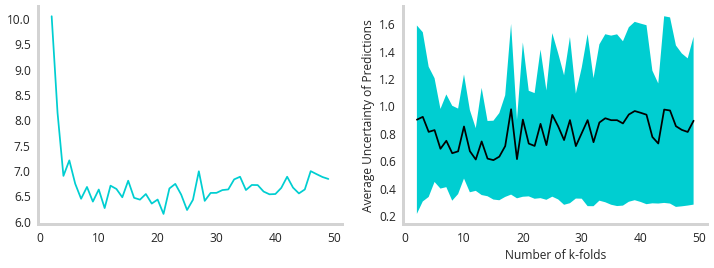

In [23]:
fig,ax=plt.subplots(1,2,figsize=(12,4))

ax[0].plot(k_values,MSE)
y=pd.DataFrame(uncertainty_dict).mean()

error=np.std(pd.DataFrame(uncertainty_dict))

ax[1].fill_between(k_values, y-error, y+error)
ax[1].plot(k_values,y,color='black')
ax[1].set_xlabel('Number of k-folds')
ax[1].set_ylabel('Average Uncertainty of Predictions')